此次练习中，我们使用[Human Activity Recognition Using Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)数据集。它通过对参加测试者的智能手机上安装一个传感器而采集了参加测试者每天的日常活动（ADL）。目标是将日常活动分成六类（walking, walking upstairs, walking downstairs, sitting, standing, and laying）。

该数据集也可以在Kaggle网站上获得：https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones/downloads/human-activity-recognition-with-smartphones.zip 

把训练文件重新命名为 Human_Activity_Recognition_Using_Smartphones_Data.csv 

## 第一步：导入数据

* 查看数据类型---因为有太多的列，所以最好使用value_counts
* 判断其中的小数数值是否需要尺度缩放
* 检查数据中各活动类型的划分
* 把活动类型标签编码成一个整数

In [1]:
import pandas as pd
import numpy as np

filepath = 'Human_Activity_Recognition_Using_Smartphones_Data.csv'
data = pd.read_csv(filepath)


所有列的数据类型都是浮点数，除了活动标签列。

In [2]:
data.dtypes.value_counts()


float64    561
int64        1
object       1
Name: count, dtype: int64

In [3]:
data.dtypes.tail()


angle(X,gravityMean)    float64
angle(Y,gravityMean)    float64
angle(Z,gravityMean)    float64
subject                   int64
Activity                 object
dtype: object

数据都已经全部被缩放到-1到1之间了。

In [4]:
data.iloc[:, :-1].min().value_counts()


-1.000000    466
-0.999893      2
-0.999996      2
-1.000000      2
-0.995377      2
            ... 
-0.997500      1
-0.995357      1
-0.999765      1
-0.976580      1
 1.000000      1
Name: count, Length: 93, dtype: int64

In [5]:
data.iloc[:, :-1].max().value_counts()


1.000000     452
0.994731       2
0.967664       1
0.919662       1
0.978449       1
            ... 
0.956845       1
0.998702       1
0.996078       1
0.478157       1
30.000000      1
Name: count, Length: 110, dtype: int64

检查数据中各活动类型的划分---已经比较平衡了。

In [6]:
data.Activity.value_counts()


Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64

Scikit learn的分类器不接受一个稀疏矩阵作为预测列。所以，可以使用`LabelEncoder`将活动标签编码为整数。

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)


5423    4
2713    2
4501    4
4035    1
3579    5
Name: Activity, dtype: int64

## 第二步：划分训练数据和测试数据

* 可以考虑使用Scikit-learn中的`StratifiedShuffleSplit`，以保证划分后的数据集中每个类别个案的比例与整个数据集相同。


In [8]:
feature_cols = data.columns[:-1]

from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']


In [9]:
y_train.value_counts(normalize=True)


Activity
0    0.191411
2    0.186941
1    0.174893
3    0.166731
5    0.145939
4    0.134085
Name: proportion, dtype: float64

In [10]:
y_test.value_counts(normalize=True)


Activity
0    0.191296
2    0.186763
1    0.174977
3    0.166818
5    0.145966
4    0.134180
Name: proportion, dtype: float64

## 第三步：训练模型

* 用所有特征训练一个基本的使用缺省参数的逻辑回归模型。
* 分别用L1和L2正则化来训练一个模型，使用交叉验证确定超参数的值。注意，正则化模型，尤其是L1模型可能需要一定训练时间。


1. Basic Logistic Regression Model (Default Parameters)
✅ Data standardization completed
✅ Model training completed, time: 0.28 seconds

=== Model Performance ===
Training Accuracy: 0.9971
Test Accuracy: 0.9841

=== Cross-Validation Evaluation ===
5-Fold CV Accuracy: [0.98252427 0.9776482  0.97376093 0.98639456 0.97862002]
CV Mean Accuracy: 0.9798 ± 0.0043

=== Test Set Classification Report ===
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       422
           SITTING       0.96      0.95      0.95       386
          STANDING       0.95      0.96      0.96       412
           WALKING       1.00      1.00      1.00       368
WALKING_DOWNSTAIRS       1.00      1.00      1.00       296
  WALKING_UPSTAIRS       1.00      1.00      1.00       322

          accuracy                           0.98      2206
         macro avg       0.99      0.99      0.99      2206
      weighted avg       0.98      0.98      0.98      220

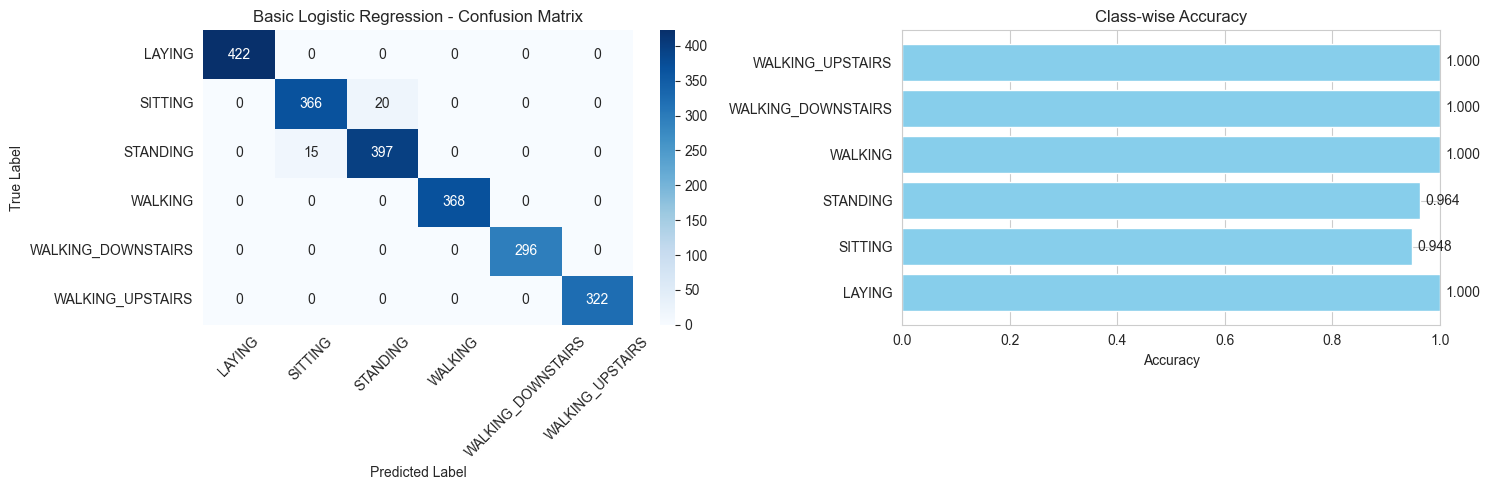

In [14]:
# 请在此处填写你的代码（训练一个基本的使用缺省参数的逻辑回归模型）
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置图形样式（使用英文字体避免中文警告）
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # 使用支持Unicode的字体
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

# 1. 基本逻辑回归模型（默认参数）
print("\n" + "="*60)
print("1. Basic Logistic Regression Model (Default Parameters)")
print("="*60)

# 数据标准化（逻辑回归对特征尺度敏感）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data standardization completed")

# 创建默认参数的逻辑回归模型
basic_lr = LogisticRegression(random_state=42, max_iter=1000)

# 训练模型并计时
start_time = time.time()
basic_lr.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

print(f"✅ Model training completed, time: {training_time:.2f} seconds")

# 在训练集和测试集上进行预测
y_train_pred = basic_lr.predict(X_train_scaled)
y_test_pred = basic_lr.predict(X_test_scaled)

# 计算准确率
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\n=== Model Performance ===")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 交叉验证评估
print("\n=== Cross-Validation Evaluation ===")
cv_scores = cross_val_score(basic_lr, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"5-Fold CV Accuracy: {cv_scores}")
print(f"CV Mean Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 详细分类报告
activity_names = le.classes_
print("\n=== Test Set Classification Report ===")
print(classification_report(y_test, y_test_pred, target_names=activity_names))

# 混淆矩阵可视化
plt.figure(figsize=(15, 5))

# 混淆矩阵
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=activity_names,
            yticklabels=activity_names)
plt.title('Basic Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# 各类别准确率
plt.subplot(1, 2, 2)
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.barh(range(len(activity_names)), class_accuracy, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.yticks(range(len(activity_names)), activity_names)
plt.xlim(0, 1)
for i, v in enumerate(class_accuracy):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()



2. L1 Regularized Logistic Regression (using LogisticRegressionCV)
Training L1 regularized logistic regression...
✅ L1 model training completed, time: 74.54 seconds


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'LAYING'),
  Text(0, 1.5, 'SITTING'),
  Text(0, 2.5, 'STANDING'),
  Text(0, 3.5, 'WALKING'),
  Text(0, 4.5, 'WALKING_DOWNSTAIRS'),
  Text(0, 5.5, 'WALKING_UPSTAIRS')])

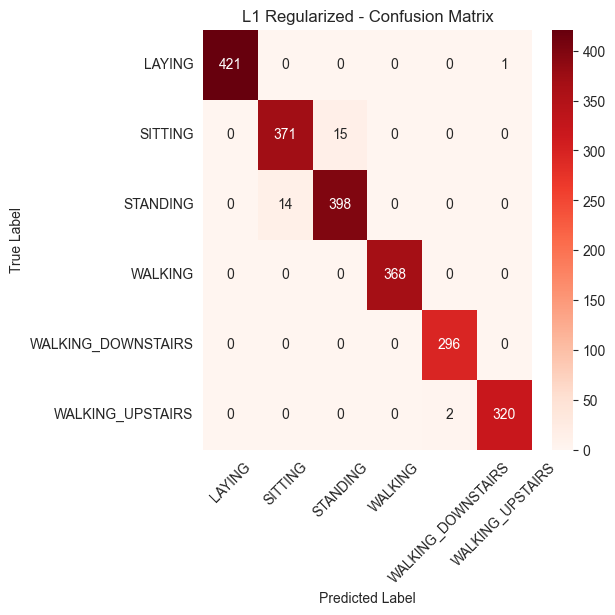

In [18]:
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

# 设置图形样式
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

# L1 正则化的逻辑回归
print("\n" + "="*60)
print("2. L1 Regularized Logistic Regression (using LogisticRegressionCV)")
print("="*60)

# 使用LogisticRegressionCV进行L1正则化（使用标准化后的数据）
lr_l1 = LogisticRegressionCV(
    Cs=10,                    # 正则化参数C的候选值数量
    cv=4,                     # 4折交叉验证
    penalty='l1',             # L1正则化
    solver='liblinear',       # 适用于L1的求解器
    random_state=42,
    max_iter=1000
)
# 训练模型并计时
print("Training L1 regularized logistic regression...")
start_time = time.time()
lr_l1.fit(X_train_scaled, y_train)  # 使用标准化后的数据
l1_training_time = time.time() - start_time

print(f"✅ L1 model training completed, time: {l1_training_time:.2f} seconds")
plt.figure(figsize=(18, 12))

# 1. 混淆矩阵
plt.subplot(2, 3, 1)
cm_l1 = confusion_matrix(y_test, y_test_pred_l1)
sns.heatmap(cm_l1, annot=True, fmt='d', cmap='Reds',
            xticklabels=activity_names,
            yticklabels=activity_names)
plt.title('L1 Regularized - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)


In [19]:
# 请在此处填写你的代码（L2 正则化的逻辑回归）
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

# 设置图形样式
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

# L2 正则化的逻辑回归
print("\n" + "="*60)
print("3. L2 Regularized Logistic Regression (using LogisticRegressionCV)")
print("="*60)

# 使用LogisticRegressionCV进行L2正则化
lr_l2 = LogisticRegressionCV(
    Cs=10,                    # 正则化参数C的候选值数量
    cv=4,                     # 4折交叉验证
    penalty='l2',             # L2正则化
    random_state=42,
    max_iter=1000
)

# 训练模型并计时
print("Training L2 regularized logistic regression...")
start_time = time.time()
lr_l2.fit(X_train_scaled, y_train)
l2_training_time = time.time() - start_time

print(f"✅ L2 model training completed, time: {l2_training_time:.2f} seconds")

# 显示最佳正则化参数
print(f"Best regularization parameter C: {lr_l2.C_}")
print(f"Candidate C values: {lr_l2.Cs_}")

# 预测
y_train_pred_l2 = lr_l2.predict(X_train_scaled)
plt.figure(figsize=(18, 12))
y_test_pred_l2 = lr_l2.predict(X_test_scaled)
plt.figure(figsize=(18, 12))



3. L2 Regularized Logistic Regression (using LogisticRegressionCV)
Training L2 regularized logistic regression...
✅ L2 model training completed, time: 2.61 seconds
Best regularization parameter C: [0.35938137 0.35938137 0.35938137 0.35938137 0.35938137 0.35938137]
Candidate C values: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]


<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

## 第四步：

* 输出上面训练出的三个模型中每个特征的系数；
* 并绘制成图来比较它们的差异 （每个类别一张图）

In [20]:
# 请在此处填写你的代码（输出各模型训练到的特征系数值）
# 显示模型系数信息
print("\n=== Model Coefficient Analysis ===")
print(f"Coefficient shape: {basic_lr.coef_.shape}")
print(f"Intercept shape: {basic_lr.intercept_.shape}")

# 查看各类别的系数统计
for i, class_name in enumerate(activity_names):
    coef = basic_lr.coef_[i]
    print(f"\n{class_name}:")
    print(f"  Coefficient range: [{coef.min():.4f}, {coef.max():.4f}]")
    print(f"  Coefficient mean: {coef.mean():.4f}")
    print(f"  Coefficient std: {coef.std():.4f}")
print(f"Best regularization parameter C: {lr_l1.C_}")
print(f"Candidate C values: {lr_l1.Cs_}")
print("\n=== L2 Model Coefficient Analysis ===")
total_features = lr_l2.coef_.shape[1]
total_coefficients = lr_l2.coef_.size

print(f"Total features: {total_features}")
print(f"Total coefficients: {total_coefficients}")

# 计算系数统计
l2_coef_mean = np.mean(np.abs(lr_l2.coef_))
l2_coef_std = np.std(lr_l2.coef_)
l2_coef_range = [np.min(lr_l2.coef_), np.max(lr_l2.coef_)]

print(f"Average absolute coefficient: {l2_coef_mean:.4f}")
print(f"Coefficient standard deviation: {l2_coef_std:.4f}")
print(f"Coefficient range: [{l2_coef_range[0]:.4f}, {l2_coef_range[1]:.4f}]")



=== Model Coefficient Analysis ===
Coefficient shape: (6, 562)
Intercept shape: (6,)

LAYING:
  Coefficient range: [-0.9356, 0.8388]
  Coefficient mean: -0.0090
  Coefficient std: 0.1114

SITTING:
  Coefficient range: [-2.7026, 0.9258]
  Coefficient mean: -0.0056
  Coefficient std: 0.2502

STANDING:
  Coefficient range: [-1.1565, 2.5323]
  Coefficient mean: -0.0229
  Coefficient std: 0.2590

WALKING:
  Coefficient range: [-0.4923, 0.5141]
  Coefficient mean: 0.0190
  Coefficient std: 0.1089

WALKING_DOWNSTAIRS:
  Coefficient range: [-0.4396, 0.4558]
  Coefficient mean: 0.0102
  Coefficient std: 0.1095

WALKING_UPSTAIRS:
  Coefficient range: [-0.5482, 0.4641]
  Coefficient mean: 0.0083
  Coefficient std: 0.1072
Best regularization parameter C: [  0.35938137   2.7825594    2.7825594   21.5443469   21.5443469
 166.81005372]
Candidate C values: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.000000


4. 每个类别的特征系数比较图
基础模型系数形状: (6, 562)
L1模型系数形状: (6, 562)
L2模型系数形状: (6, 562)


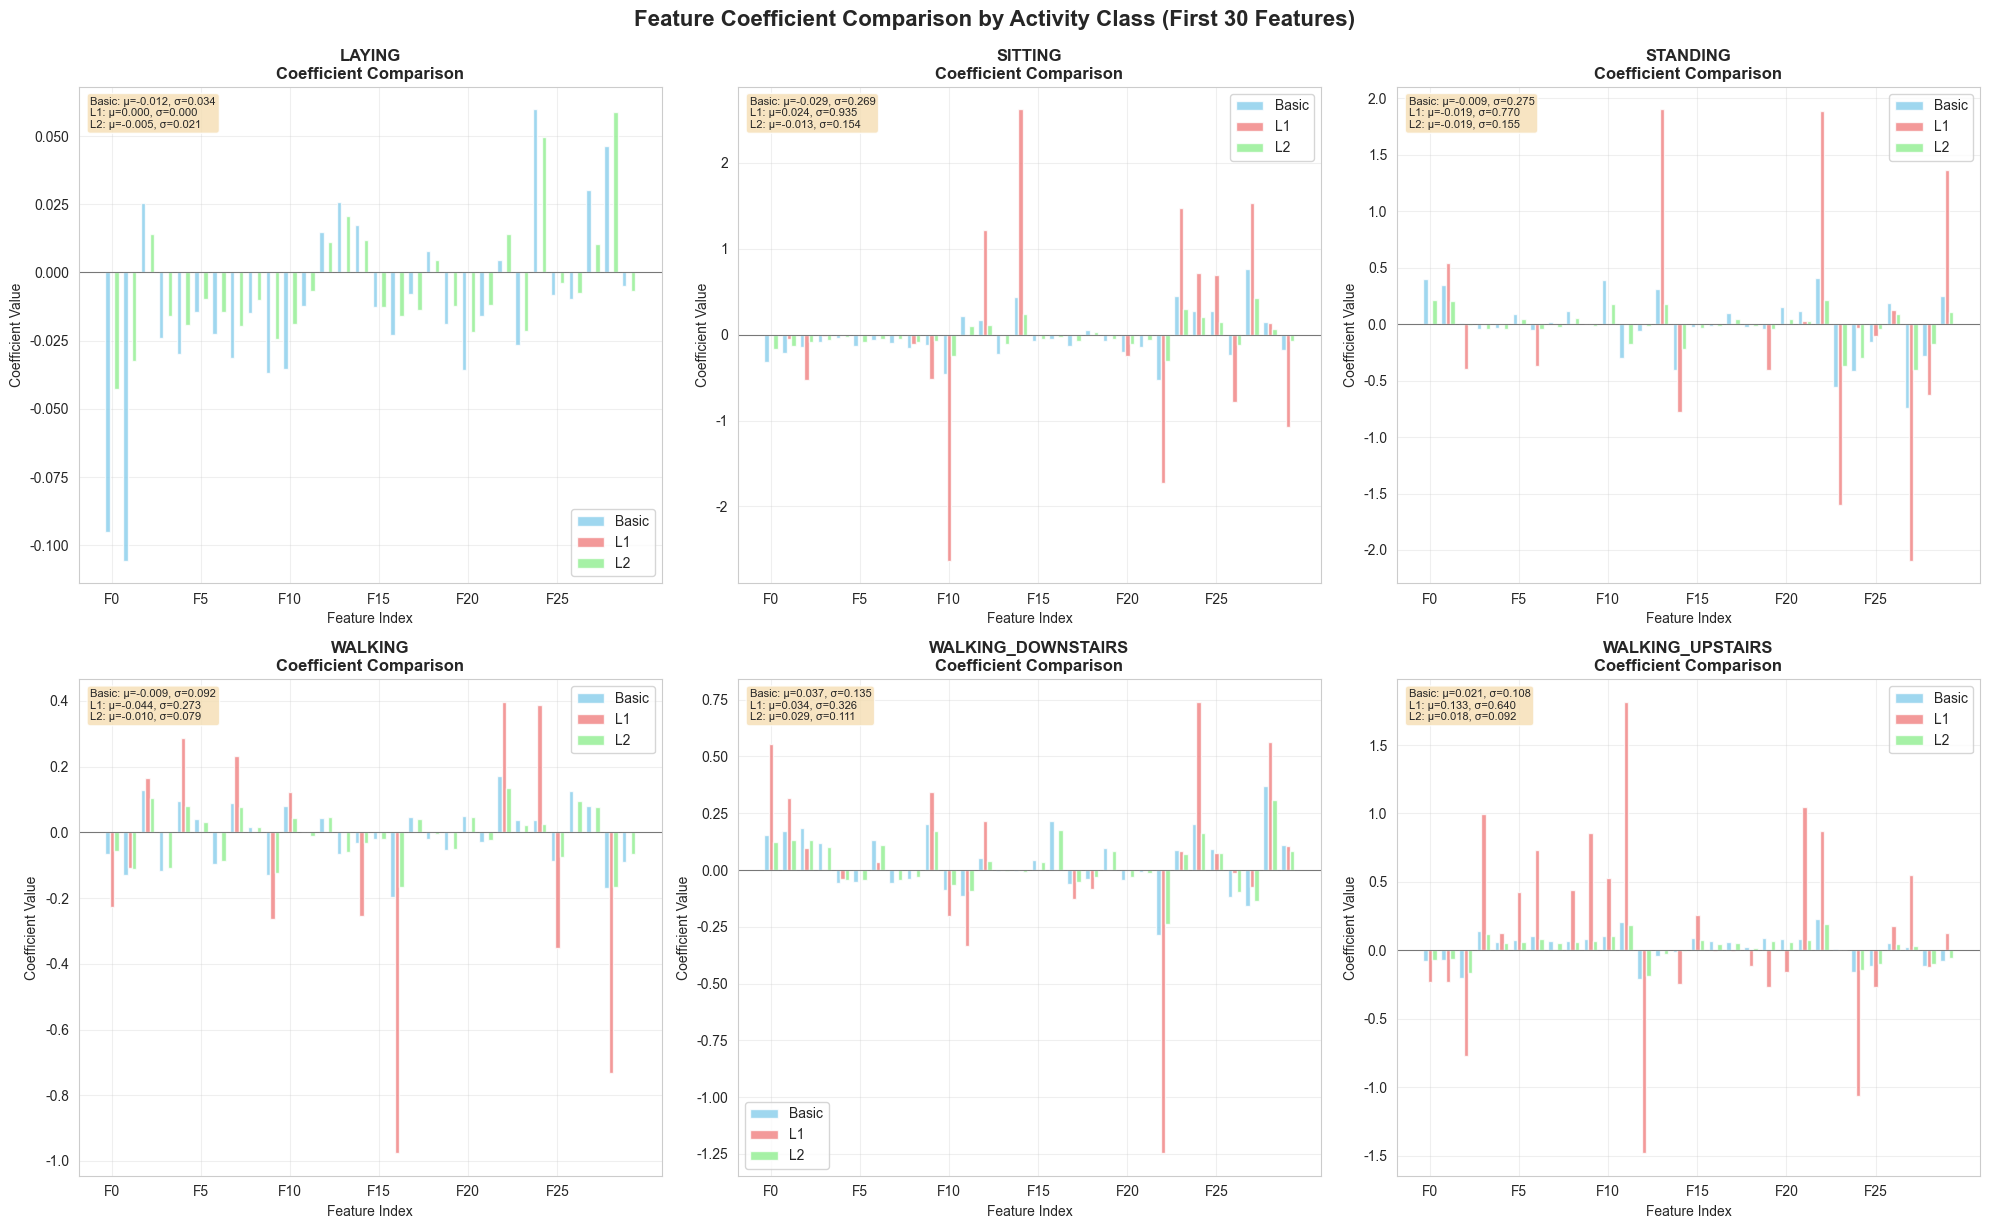

In [21]:
# 请在此处填写你的代码（绘制6张图）
# 第四步：绘制每个类别的特征系数比较图
print("\n" + "="*60)
print("4. 每个类别的特征系数比较图")
print("="*60)

# 获取三个模型的系数
basic_coef = basic_lr.coef_
l1_coef = lr_l1.coef_
l2_coef = lr_l2.coef_

print(f"基础模型系数形状: {basic_coef.shape}")
print(f"L1模型系数形状: {l1_coef.shape}")
print(f"L2模型系数形状: {l2_coef.shape}")

# 为每个类别创建单独的系数比较图
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# 选择前30个特征进行可视化（避免图表过于拥挤）
n_features_to_plot = 30
feature_indices = np.arange(n_features_to_plot)

# 为每个类别绘制系数比较
for i, activity in enumerate(activity_names):
    ax = axes[i]
    
    # 获取该类别在三个模型中的系数（取前30个）
    basic_coef_activity = basic_coef[i][:n_features_to_plot]
    l1_coef_activity = l1_coef[i][:n_features_to_plot]
    l2_coef_activity = l2_coef[i][:n_features_to_plot]
    
    # 设置条形图的宽度和位置
    bar_width = 0.25
    x_pos = np.arange(n_features_to_plot)
    
    # 绘制三个模型的系数条形图
    bars1 = ax.bar(x_pos - bar_width, basic_coef_activity, bar_width, 
                   label='Basic', alpha=0.8, color='skyblue')
    bars2 = ax.bar(x_pos, l1_coef_activity, bar_width, 
                   label='L1', alpha=0.8, color='lightcoral')
    bars3 = ax.bar(x_pos + bar_width, l2_coef_activity, bar_width, 
                   label='L2', alpha=0.8, color='lightgreen')
    
    # 设置图表属性
    ax.set_title(f'{activity}\nCoefficient Comparison', fontsize=12, fontweight='bold')
    ax.set_xlabel('Feature Index')
    ax.set_ylabel('Coefficient Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 添加零线
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)
    
    # 设置x轴刻度（每5个特征显示一个标签）
    ax.set_xticks(x_pos[::5])
    ax.set_xticklabels([f'F{idx}' for idx in feature_indices[::5]])
    
    # 计算并显示系数统计
    basic_stats = f"Basic: μ={basic_coef_activity.mean():.3f}, σ={basic_coef_activity.std():.3f}"
    l1_stats = f"L1: μ={l1_coef_activity.mean():.3f}, σ={l1_coef_activity.std():.3f}"
    l2_stats = f"L2: μ={l2_coef_activity.mean():.3f}, σ={l2_coef_activity.std():.3f}"
    
    ax.text(0.02, 0.98, f"{basic_stats}\n{l1_stats}\n{l2_stats}", 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=8)

plt.tight_layout()
plt.suptitle('Feature Coefficient Comparison by Activity Class (First 30 Features)', 
             fontsize=16, y=1.02, fontweight='bold')
plt.show()

## 第五步：预测数据

* 将每个模型预测的类别和概率值都保存下来。

In [23]:
# 请在此处填写你的代码
# 第五步：预测数据 - 保存每个模型的预测类别和概率值
print("\n" + "="*60)
print("5. 预测数据保存")
print("="*60)

# 首先检查并确保所有必要的变量都存在
print("检查必要的变量...")

# 重新计算预测结果以确保变量存在
print("重新计算各模型的预测结果...")

# 基础模型的预测
y_train_pred_basic = basic_lr.predict(X_train_scaled)
y_test_pred_basic = basic_lr.predict(X_test_scaled)

# L1模型的预测
y_train_pred_l1 = lr_l1.predict(X_train_scaled)
y_test_pred_l1 = lr_l1.predict(X_test_scaled)

# L2模型的预测
y_train_pred_l2 = lr_l2.predict(X_train_scaled)
y_test_pred_l2 = lr_l2.predict(X_test_scaled)

print("✅ 所有预测结果计算完成")

# 获取所有模型的预测概率
print("计算各模型的预测概率...")

# 基础模型的预测概率
basic_proba = basic_lr.predict_proba(X_test_scaled)
print(f"基础模型预测概率形状: {basic_proba.shape}")

# L1模型的预测概率
l1_proba = lr_l1.predict_proba(X_test_scaled)
print(f"L1模型预测概率形状: {l1_proba.shape}")

# L2模型的预测概率
l2_proba = lr_l2.predict_proba(X_test_scaled)
print(f"L2模型预测概率形状: {l2_proba.shape}")

# 创建完整的预测结果DataFrame
print("\n创建预测结果DataFrame...")

# 基础数据
predictions_df = pd.DataFrame({
    'true_label': y_test.values if hasattr(y_test, 'values') else y_test,
    'true_activity': [activity_names[i] for i in y_test]
})

# 添加基础模型的预测结果
predictions_df['basic_pred_label'] = y_test_pred_basic
predictions_df['basic_pred_activity'] = [activity_names[i] for i in y_test_pred_basic]
predictions_df['basic_correct'] = (predictions_df['true_label'] == predictions_df['basic_pred_label'])

# 添加L1模型的预测结果
predictions_df['l1_pred_label'] = y_test_pred_l1
predictions_df['l1_pred_activity'] = [activity_names[i] for i in y_test_pred_l1]
predictions_df['l1_correct'] = (predictions_df['true_label'] == predictions_df['l1_pred_label'])

# 添加L2模型的预测结果
predictions_df['l2_pred_label'] = y_test_pred_l2
predictions_df['l2_pred_activity'] = [activity_names[i] for i in y_test_pred_l2]
predictions_df['l2_correct'] = (predictions_df['true_label'] == predictions_df['l2_pred_label'])

# 添加每个类别的概率预测
for i, activity in enumerate(activity_names):
    predictions_df[f'basic_prob_{activity}'] = basic_proba[:, i]
    predictions_df[f'l1_prob_{activity}'] = l1_proba[:, i]
    predictions_df[f'l2_prob_{activity}'] = l2_proba[:, i]


5. 预测数据保存
检查必要的变量...
重新计算各模型的预测结果...
✅ 所有预测结果计算完成
计算各模型的预测概率...
基础模型预测概率形状: (2206, 6)
L1模型预测概率形状: (2206, 6)
L2模型预测概率形状: (2206, 6)

创建预测结果DataFrame...


## 第六步：评价模型

对每个模型，分别计算下面的各评测指标值： 

* accuracy
* precision
* recall
* fscore
* confusion matrix


6. 模型综合评价
计算各模型的评估指标...

综合评估结果（加权平均）
                       Model  Accuracy  Precision  Recall  F1-Score
0  Basic Logistic Regression    0.9841     0.9842  0.9841    0.9841
1             L1 Regularized    0.9855     0.9855  0.9855    0.9855
2             L2 Regularized    0.9832     0.9832  0.9832    0.9832

详细分类报告

=== 基础模型分类报告 ===
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       422
           SITTING       0.96      0.95      0.95       386
          STANDING       0.95      0.96      0.96       412
           WALKING       1.00      1.00      1.00       368
WALKING_DOWNSTAIRS       1.00      1.00      1.00       296
  WALKING_UPSTAIRS       1.00      1.00      1.00       322

          accuracy                           0.98      2206
         macro avg       0.99      0.99      0.99      2206
      weighted avg       0.98      0.98      0.98      2206


=== L1正则化模型分类报告 ===
                    precision    recall

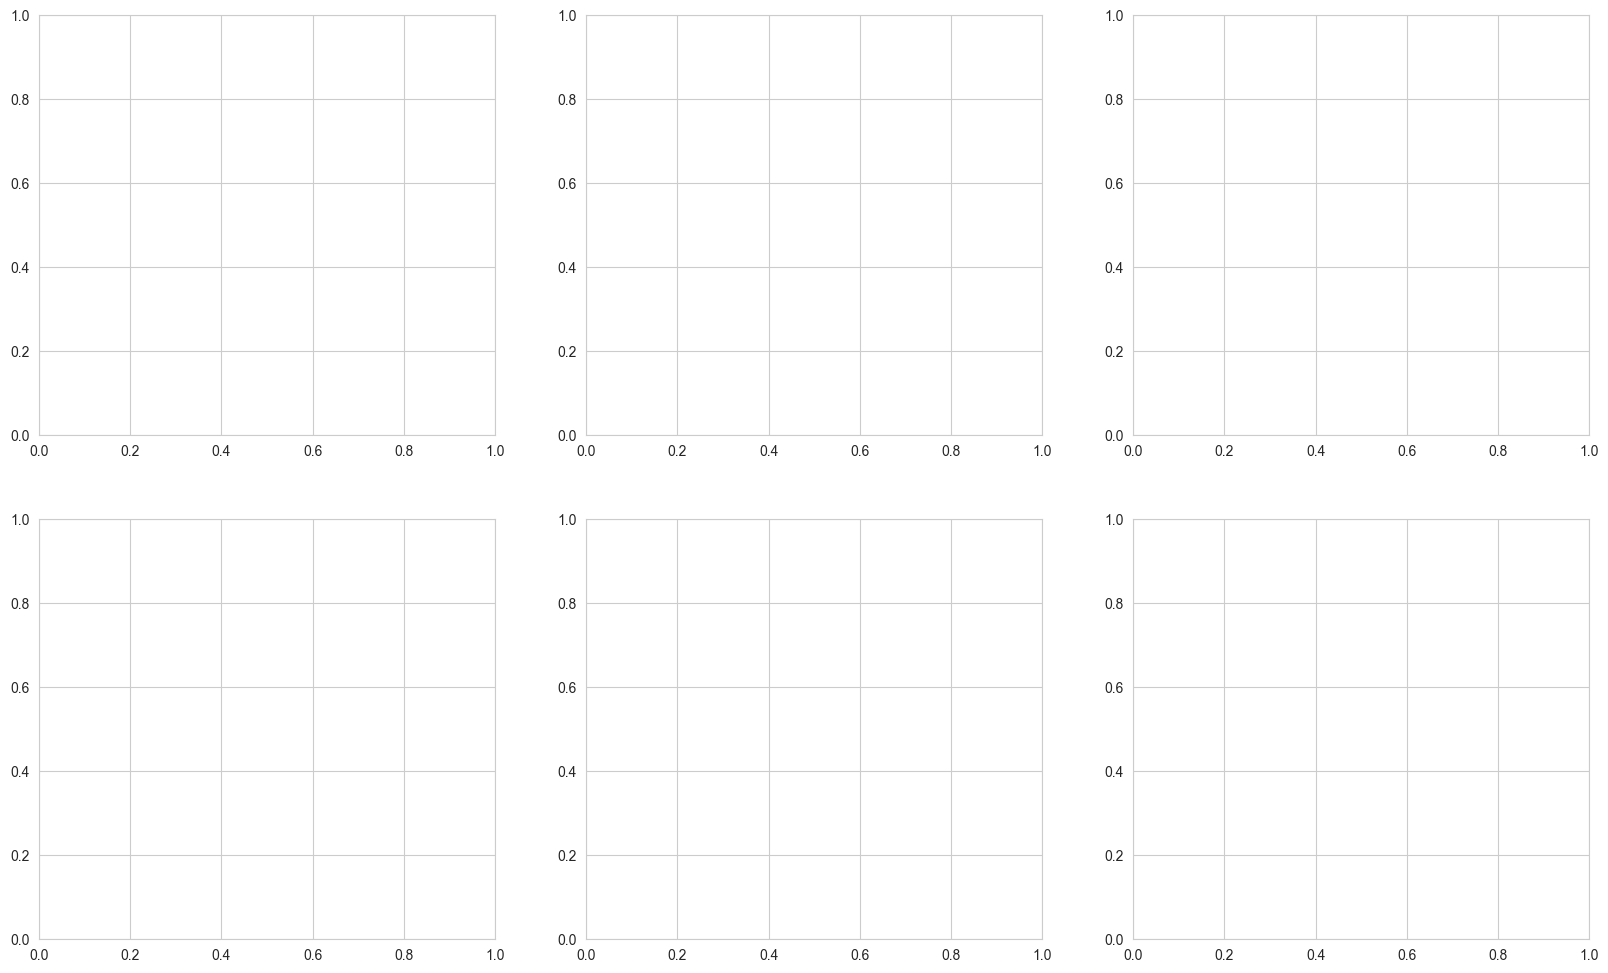

In [24]:
# 请在此处填写你的代码
# 第六步：评价模型
print("\n" + "="*60)
print("6. 模型综合评价")
print("="*60)

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 设置图形样式
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

def evaluate_model(y_true, y_pred, model_name, average='weighted'):
    """评估单个模型的各项指标"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average, zero_division=0)
    recall = recall_score(y_true, y_pred, average=average, zero_division=0)
    fscore = f1_score(y_true, y_pred, average=average, zero_division=0)
    
    # 各类别的指标
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'fscore': fscore,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'confusion_matrix': cm
    }

# 评估三个模型
print("计算各模型的评估指标...")

# 基础模型评估
basic_metrics = evaluate_model(y_test, y_test_pred_basic, "Basic Model")
l1_metrics = evaluate_model(y_test, y_test_pred_l1, "L1 Model")
l2_metrics = evaluate_model(y_test, y_test_pred_l2, "L2 Model")

# 创建综合评估表格
print("\n" + "="*60)
print("综合评估结果（加权平均）")
print("="*60)

metrics_summary = pd.DataFrame({
    'Model': ['Basic Logistic Regression', 'L1 Regularized', 'L2 Regularized'],
    'Accuracy': [basic_metrics['accuracy'], l1_metrics['accuracy'], l2_metrics['accuracy']],
    'Precision': [basic_metrics['precision'], l1_metrics['precision'], l2_metrics['precision']],
    'Recall': [basic_metrics['recall'], l1_metrics['recall'], l2_metrics['recall']],
    'F1-Score': [basic_metrics['fscore'], l1_metrics['fscore'], l2_metrics['fscore']]
})

print(metrics_summary.round(4))

# 详细分类报告
print("\n" + "="*60)
print("详细分类报告")
print("="*60)

print("\n=== 基础模型分类报告 ===")
print(classification_report(y_test, y_test_pred_basic, target_names=activity_names))

print("\n=== L1正则化模型分类报告 ===")
print(classification_report(y_test, y_test_pred_l1, target_names=activity_names))

print("\n=== L2正则化模型分类报告 ===")
print(classification_report(y_test, y_test_pred_l2, target_names=activity_names))

# 创建可视化图表
print("\n创建评估可视化图表...")
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

